In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import  StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             roc_auc_score, 
                             roc_curve,
                             precision_score, 
                             recall_score, 
                             f1_score, 
                             classification_report, 
                             confusion_matrix)
from tqdm import tqdm

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [3]:
# 1. Đọc dữ liệu
df_train = pd.read_parquet('train.parquet')
df_valid = pd.read_parquet('validation.parquet')
df_test  = pd.read_parquet('test.parquet')

In [4]:

# 2. Cột loại bỏ
cols_to_drop = [
    'fraud',
    'ngay_hhluc_khang', 'ngay_hhluc_vitri_ddo', 'ngay_hhluc_diemdo', 'ngay_hhluc',
    'id_bcs', 'ngay_kdinh', 'loai_chiso', 'ngay_hluc_diem_do', 'ngay_hluc_vitri_ddo',
    'thang_csuat_ddo', 'ngay_hluc_khang', 'gia_tri', 'loai_giatri', 'kimua_cspk',
    'id_ddo', 'ma_dviqly', 'so_cot', 'so_hop', 'ma_dvictren', 'ky', 'thang', 'nam',
    'sluong_ttiep', 'sluong_trphu', 'thd_le', 'ma_cnang_chiso', 'ngay_bdong',
    'id_khang', 'so_pha', 'ngay_tao_chiso', 'nguoi_tao_chiso', 'ngay_sua_chiso',
    'nguoi_sua_chiso', 'ngay_hluc'
]

# 3. Tách X, y
X_train = df_train.drop(columns=cols_to_drop)
y_train = df_train['fraud']
X_valid = df_valid.drop(columns=cols_to_drop)
y_valid = df_valid['fraud']
X_test = df_test.drop(columns=cols_to_drop)
y_test = df_test['fraud']

[Text(0, 0.5, '4379497'), Text(0, 0.5, '56164')]

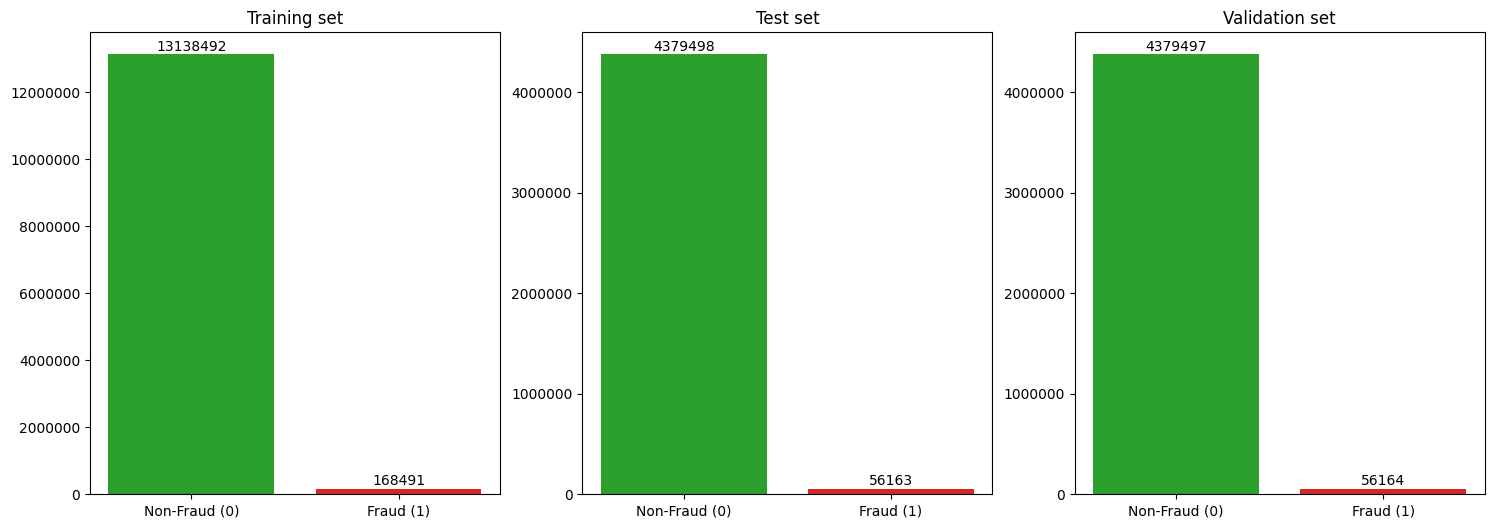

In [8]:
import matplotlib.pyplot as plt

# Tinh so luong  fraud va nonfraud trong 3 tap train, test va validation
non_fraud_train, fraud_train = y_train.value_counts()
non_fraud_test, fraud_test = y_test.value_counts()
non_fraud_valid, fraud_valid = y_valid.value_counts()

# Ve bieu do bar chart the hien so luong fraud va non fraud
x = ['Non-Fraud (0)', 'Fraud (1)']
y1 = [non_fraud_train, fraud_train]
y2 = [non_fraud_test, fraud_test]
y3 = [non_fraud_valid, fraud_valid]
bar_color = ['tab:green','tab:red']

fig, axs = plt.subplots(1,3, figsize=(18,6))

bar1 = axs[0].bar(x, y1, color=bar_color)
axs[0].set_title('Training set')
axs[0].ticklabel_format(style='plain', axis='y')
axs[0].bar_label(bar1, padding= 0.5, fmt = '{:.0f}')

bar2 = axs[1].bar(x, y2, color=bar_color)
axs[1].set_title('Test set')
axs[1].ticklabel_format(style='plain', axis='y')
axs[1].bar_label(bar2, padding= 0.5, fmt = '{:.0f}')

bar3 = axs[2].bar(x, y3, color=bar_color)
axs[2].set_title('Validation set')
axs[2].ticklabel_format(style='plain', axis='y')
axs[2].bar_label(bar3, padding= 0.5, fmt = '{:.0f}')



Imbalance dataset

In [9]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
import lightgbm as lgbm

In [10]:
X_train_res = pd.concat([X_train,X_valid], axis = 0)
y_train_res = pd.concat([y_train,y_valid], axis = 0)

In [16]:
model = LGBMClassifier(boosting_type='gbdt',
                       n_estimators=100,
                       max_depth=-1,
                       min_child_samples=3,
                       random_state=42,
                       verbosity=-1)
model.fit(X_train_res, y_train_res)

LGBMClassifier(min_child_samples=3, random_state=42, verbosity=-1)

In [12]:
def evaluate_partial_auc(y_true, y_pred_proba):
    min_tpr = 0.80  # Ngưỡng TPR tối thiểu
    max_fpr = abs(1 - min_tpr)  # Ngưỡng FPR tối đa
    
    v_gt = abs(y_true - 1)  # Chuyển đổi y_true thành lớp tích cực (1) và lớp tiêu cực (0)
    v_pred = np.array([1.0 - x for x in y_pred_proba])  # Chuyển đổi xác suất dự đoán thành lớp tiêu cực
    
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)  # Tính AUC của phần có FPR giới hạn
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)  # Điều chỉnh AUC

    return partial_auc



In [13]:
y_pred = model.predict_proba(X_test)[:, 1]
p_auc = evaluate_partial_auc(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

print(f" AUC: {auc:.4f}, pAUC: {p_auc:.4f}")

 AUC: 0.9933, pAUC: 0.1944


Hybrid Sampling Ratio Selection Algorithm

In [14]:
def hybrid_sampling_ratio_search(X_train_res, y_train_res, X_test, y_test,
                                  ratios_undersample, ratios_oversample):
    best_score = 0
    best_ratio = (0, 0)
    best_model = None
    results = []

    for r_u in ratios_undersample:
        for r_o in ratios_oversample:
            try:
                # Step 1: Undersample majority class
                rus = RandomUnderSampler(sampling_strategy=r_u, random_state=42)
                X_res1, y_res1 = rus.fit_resample(X_train_res, y_train_res)

                # Step 2: Oversample minority class
                smote = SMOTE(sampling_strategy=r_o, random_state=42)
                X_res2, y_res2 = smote.fit_resample(X_res1, y_res1)
            except ValueError as ve:
                print(f"Bỏ qua (Under={r_u}, Over={r_o}): {ve}")
                continue

            # Step 3: Train model trên tập đã sampling
            model = LGBMClassifier(boosting_type='gbdt',
                                   n_estimators=100,
                                   max_depth=-1,
                                   min_child_samples=3,
                                   random_state=42,
                                   verbosity=-1)
            model.fit(X_res2, y_res2)

            # Step 4: Đánh giá trên tập validation cố định
            y_pred = model.predict_proba(X_test)[:, 1]
            auc = roc_auc_score(y_test, y_pred)
            p_auc = evaluate_partial_auc(y_test, y_pred)

            print(f"Ratio (Under={r_u}, Over={r_o}) → AUC: {auc:.4f}, pAUC: {p_auc:.4f}")
            results.append((r_u, r_o, auc, p_auc))

            if p_auc > best_score:
                best_score = p_auc
                best_ratio = (r_u, r_o)
                best_model = model

    print(f"\n Best ratio: Under={best_ratio[0]}, Over={best_ratio[1]} → Best pAUC: {best_score:.4f}")
    return best_model, best_ratio, best_score, results


In [15]:
ratios_undersample = [round(r, 2) for r in np.arange(0.1, 0.91, 0.1)]
ratios_oversample = [round(r, 2) for r in np.arange(0.1, 0.91, 0.1)]

best_model, best_ratio, best_pauc, results = hybrid_sampling_ratio_search(
    X_train_res, y_train_res, X_test, y_test,
    ratios_undersample, ratios_oversample
)

Bỏ qua (Under=0.1, Over=0.1): The specified ratio required to remove samples from the minority class while trying to generate new samples. Please increase the ratio.
Ratio (Under=0.1, Over=0.2) → AUC: 0.9973, pAUC: 0.1984
Ratio (Under=0.1, Over=0.3) → AUC: 0.9971, pAUC: 0.1984
Ratio (Under=0.1, Over=0.4) → AUC: 0.9970, pAUC: 0.1984
Ratio (Under=0.1, Over=0.5) → AUC: 0.9971, pAUC: 0.1984
Ratio (Under=0.1, Over=0.6) → AUC: 0.9969, pAUC: 0.1984
Ratio (Under=0.1, Over=0.7) → AUC: 0.9969, pAUC: 0.1984
Ratio (Under=0.1, Over=0.8) → AUC: 0.9970, pAUC: 0.1984
Ratio (Under=0.1, Over=0.9) → AUC: 0.9968, pAUC: 0.1984
Bỏ qua (Under=0.2, Over=0.1): The specified ratio required to remove samples from the minority class while trying to generate new samples. Please increase the ratio.
Bỏ qua (Under=0.2, Over=0.2): The specified ratio required to remove samples from the minority class while trying to generate new samples. Please increase the ratio.
Ratio (Under=0.2, Over=0.3) → AUC: 0.9973, pAUC: 0.198

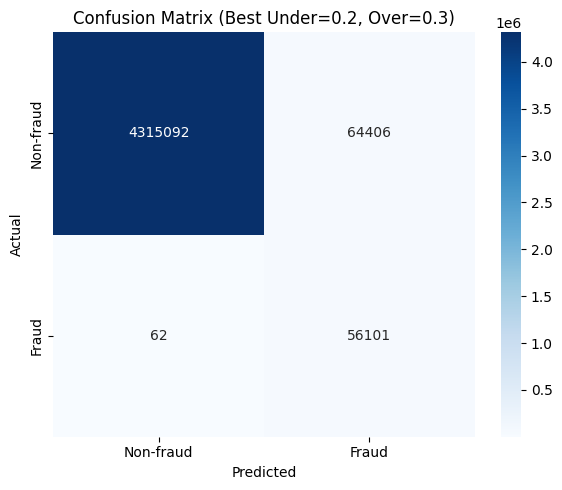

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_pred_label = (y_pred_proba >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_label)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-fraud', 'Fraud'],
            yticklabels=['Non-fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Best Under={best_ratio[0]}, Over={best_ratio[1]})')
plt.tight_layout()
plt.show()
